In [71]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [72]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
# from fpm_01 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

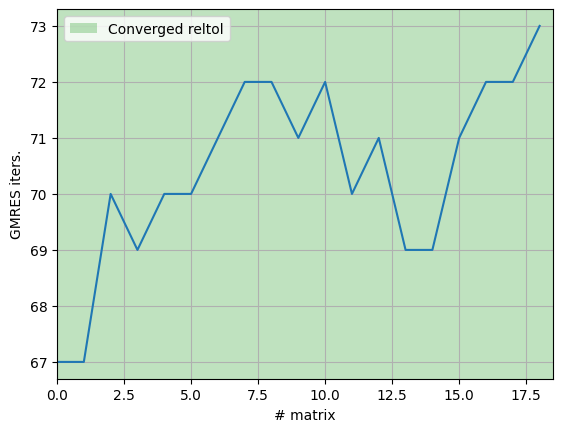

In [73]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [74]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

72

In [75]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 68
sliding = 0
open = 4
transition = 72
total = 72


In [76]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

Solve  took: 0.2
True residual decrease: 2.5832599594300484e-06


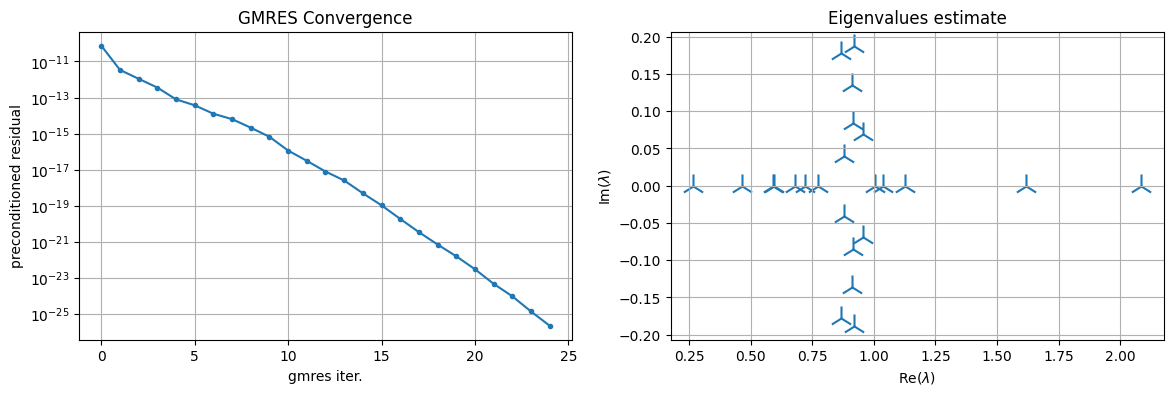

In [77]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs), tol=1e-15)

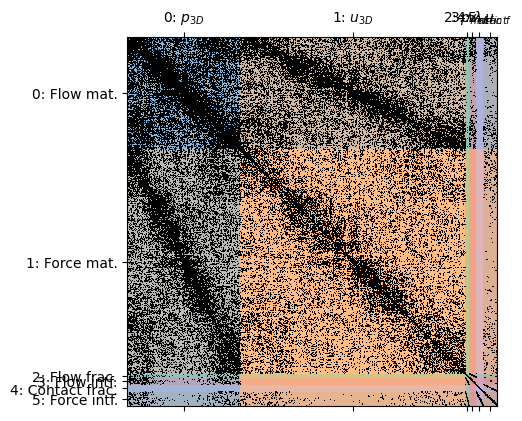

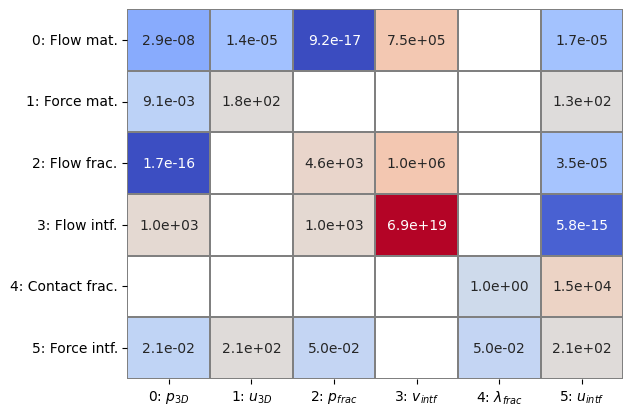

In [78]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

J = model.bmat
J.groups_row_names = [
    r"Flow mat.",
    r"Force mat.",
    r"Flow frac.",
    r"Flow intf.",
    r"Contact frac.",
    "Force intf.",
]
J.groups_col_names = [
    r"$p_{3D}$",
    r"$u_{3D}$",
    r"$p_{frac}$",
    r"$v_{intf}$",
    r"$\lambda_{frac}$",
    "$u_{intf}$",
]

J[:].color_spy()
J[:].plot_max()

# Good one

Solve  took: 0.2
True residual decrease: 2.5832599594300484e-06


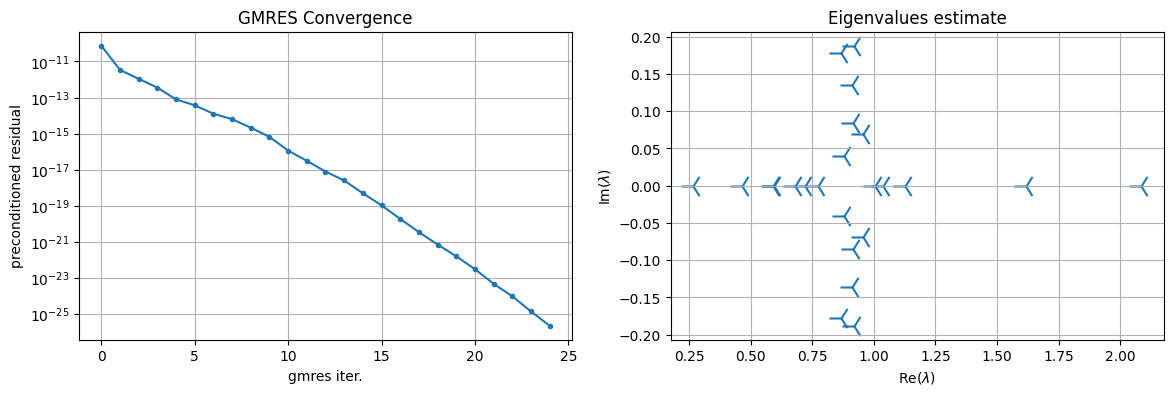

In [79]:
from block_matrix import SolveSchema, make_solver
from fixed_stress import get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(bmat[[3]].mat),
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-15, pc_side='left')

# Naive approach

Solve  took: 0.13
True residual decrease: 1.4130357106596703e-05


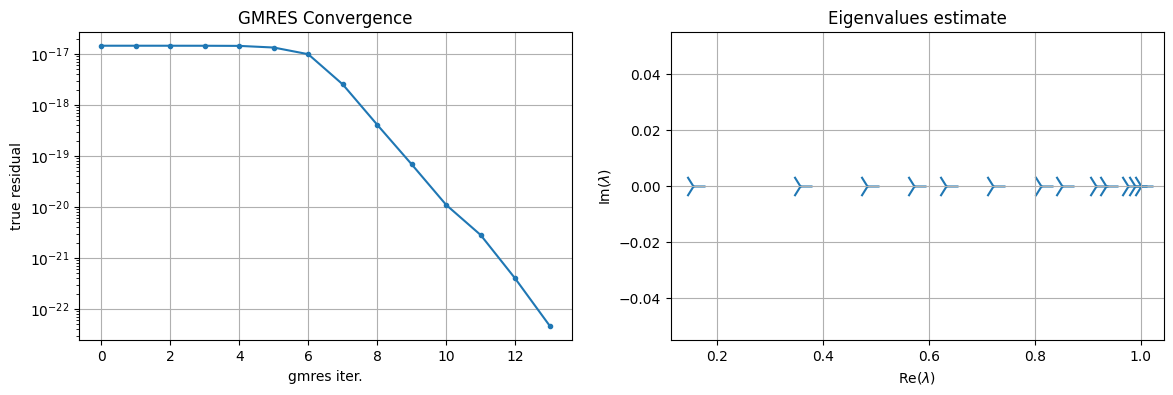

In [80]:
schema = SolveSchema(
    groups=[2, 3, 4, 5],
    complement=SolveSchema(
        groups=[1],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1]].mat, dim=model.nd),
        invertor=lambda bmat: get_fixed_stress_stabilization(model),
        invertor_type="physical",
        complement=SolveSchema(
            groups=[0],
            solve=lambda bmat: PetscAMGFlow(mat=bmat[[0]].mat),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), pc_side='right', tol=1e-5)